In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from tqdm import trange

import os
import sys

sys.path.append('../')

from bion_rectangle.behav.slam_pixel_grid import (
    AgentState, 
    Control, 
    Retina, 
)
from bion_rectangle.environment import (
    GenerativeModelSingleEnvContTabular, 
    ObserverNav, 
)
from bion_rectangle.utils import numpytorch as np2
from bion_rectangle.behav.env_boundary import LargeSquare

from bion_rectangle.utils.numpytorch import zeros_like as npt_zeros_like
from bion_rectangle.utils.numpytorch import pconc2conc
from bion_rectangle.utils.np2 import deg2rad

from torch import distributions

from utils.evaluation_utils import inverse_transform_evaluation_partical_filtering
from bion_rectangle.particle_filtering.particle_filtering import ParticleFiltering
from bion_rectangle.particle_filtering.transition_kernel import BionTransitionKernel
from bion_rectangle.particle_filtering.observation_kernel import BionObservationKernel

torch.set_default_dtype(torch.float64)

import pickle

from copy import deepcopy

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def update_state(obs_cont, control):
    dh = control.dheading_deg[-1] * obs_cont.dt
    angle = np.deg2rad(obs_cont.gen.agent_state.heading_deg + dh)
    dxdy = (np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]]) @
            np.array([control.velocity_ego[0], control.velocity_ego[1]])) * obs_cont.dt
    obs_cont.gen.agent_state.set_state((obs_cont.gen.agent_state.loc_xy[0] + dxdy[0],
                                    obs_cont.gen.agent_state.loc_xy[1] + dxdy[1]),
                                   obs_cont.gen.agent_state.heading_deg + dh)
    return

In [7]:
num_particles = 2048
num_timestep = 20

env = LargeSquare(contrast=0.5, contrast_btw_walls=0.0, height_wall=.3) # contrast between walls, consider 0.3
retina = Retina(fov_deg=(90., 90.), deg_per_pix=2.)
gen_cont = GenerativeModelSingleEnvContTabular(env=env, retina=retina)
obs_cont = ObserverNav(gen_cont, (0., 0.),
                            .85, (0.3, 0.))

agent_pos = torch.tensor([0.3, 0.3, 120.])
control = Control(15, (0.1, 0.))
obs_cont.gen.agent_state.set_state((agent_pos[0], agent_pos[1]), agent_pos[2])

transition_kernel_kwargs = {
    "dt": 1., 
    "corners": gen_cont.env.corners, 
}
observation_kernel_kwargs = {
    "duration": 1., 
}

particles = ParticleFiltering(num_particles, BionTransitionKernel, BionObservationKernel, gen_cont,
                                transition_kernel_kwargs=transition_kernel_kwargs, observation_kernel_kwargs=observation_kernel_kwargs, 
                                resampling_loc_std=0.03, resampling_hd_std=2.0)

particle_locs_and_hd = np.zeros((num_timestep, num_particles, 3))
particle_weights = np.zeros((num_timestep, num_particles))
true_locs = np.zeros((num_timestep, 2))
true_hd = np.zeros((num_timestep, 1))

true_locs[0] = obs_cont.gen.agent_state.loc_xy
true_hd[0] = obs_cont.gen.agent_state.heading_deg

In [8]:
with trange(20, dynamic_ncols=True) as pbar:
    for i in pbar:
        if i > 0:
            update_state(obs_cont, control)
            
            true_locs[i] = obs_cont.gen.agent_state.loc_xy
            true_hd[i] = obs_cont.gen.agent_state.heading_deg

        particle_mean, particle_var = particles.step(
            gen_cont, control, obs_cont.noise_control_rotate_pconc[0], noise_control_shift_per_speed = obs_cont.noise_control_shift_per_speed[:]
        )

        particle_locs_and_hd[i] = particles.particles
        particle_weights[i] = particles.w

100%|██████████| 20/20 [04:04<00:00, 12.20s/it]


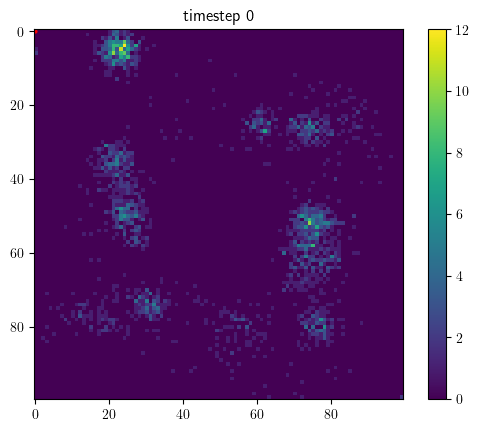

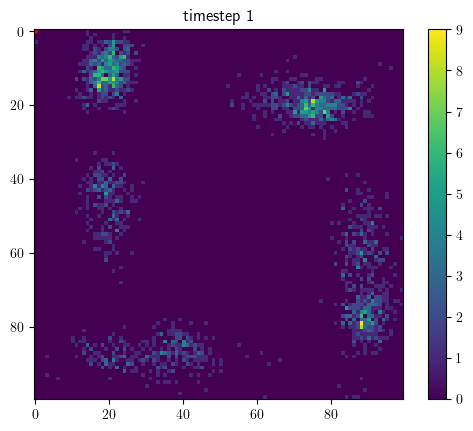

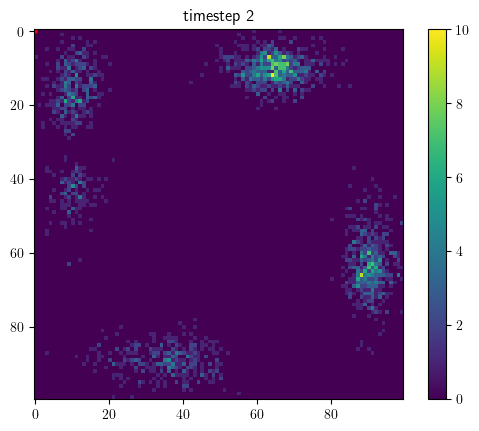

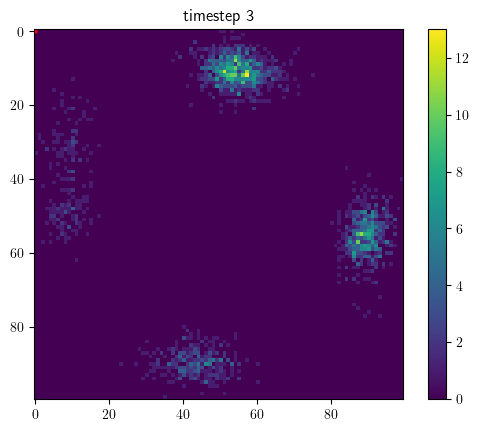

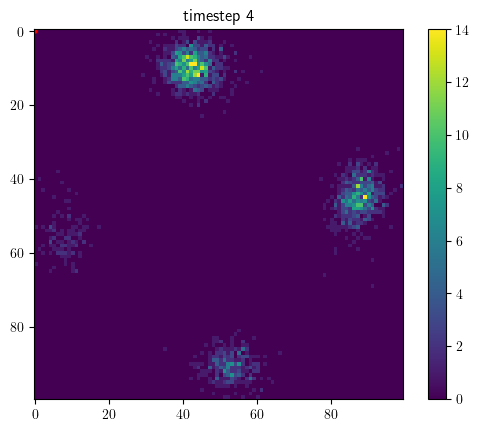

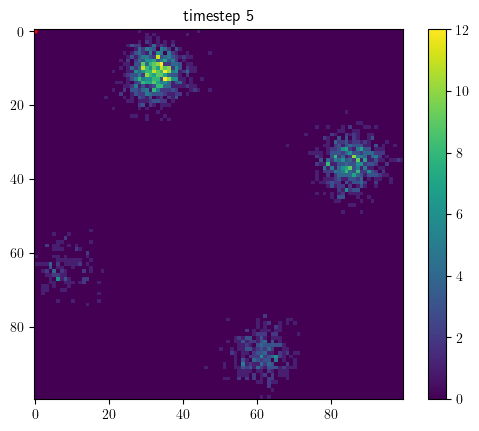

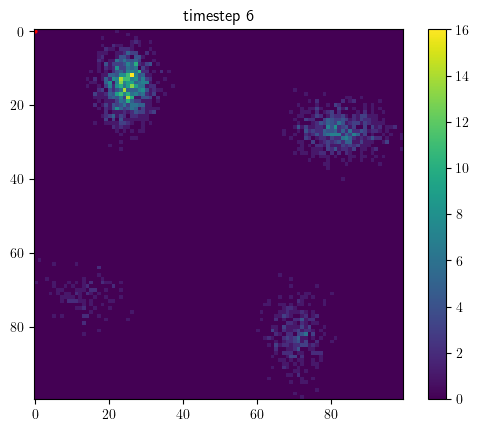

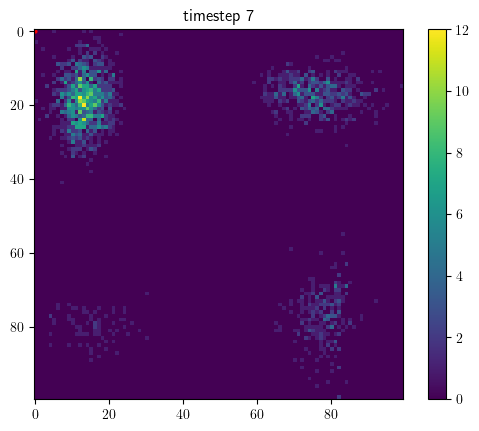

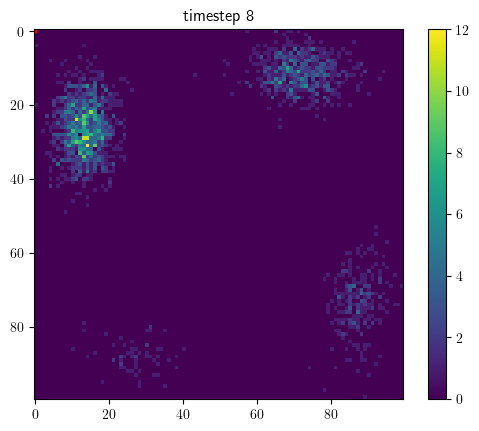

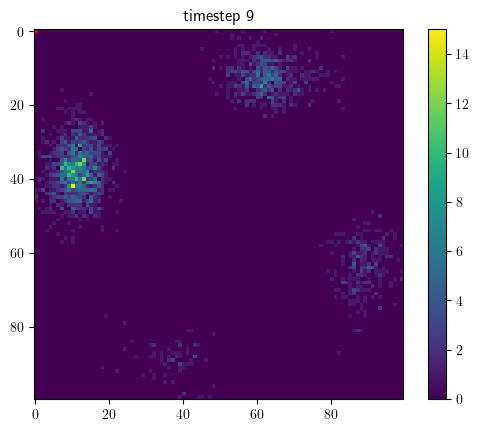

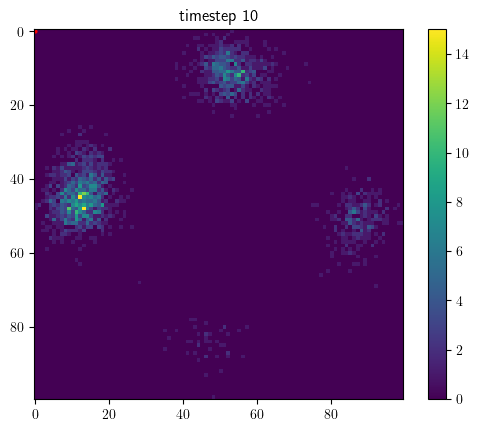

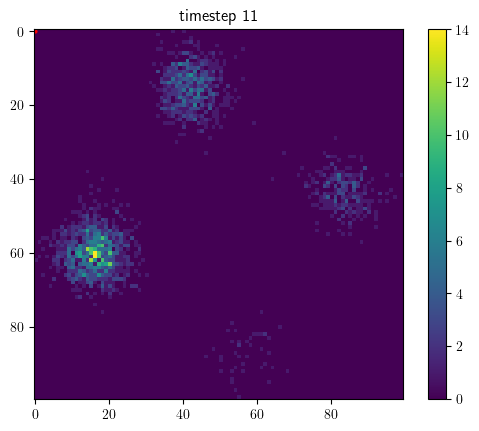

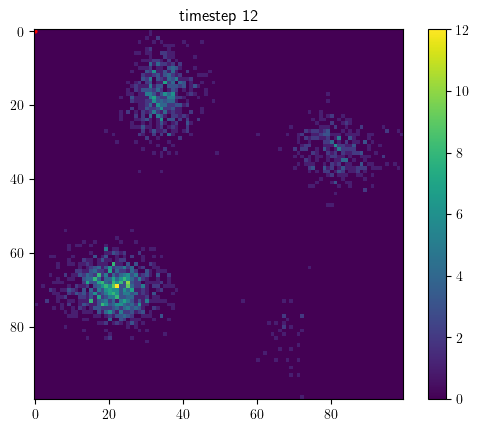

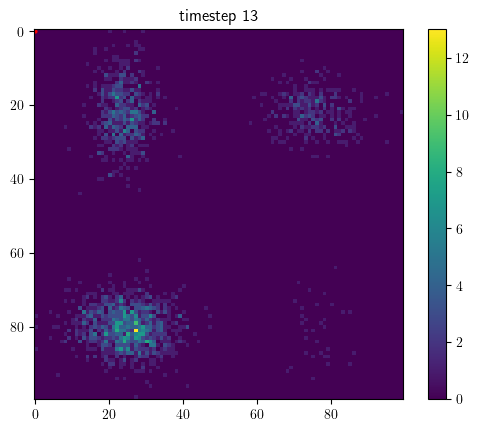

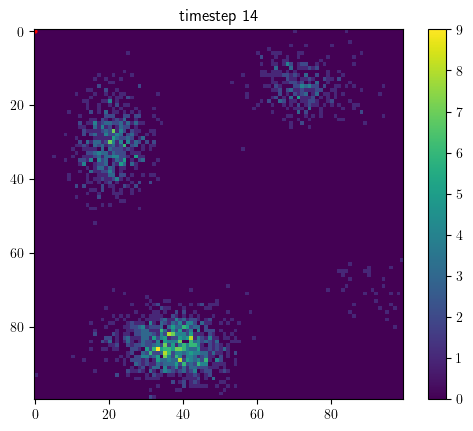

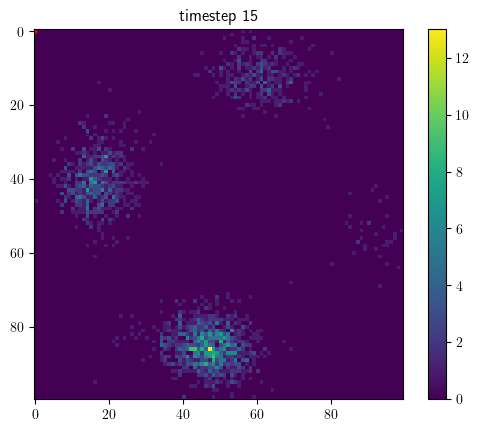

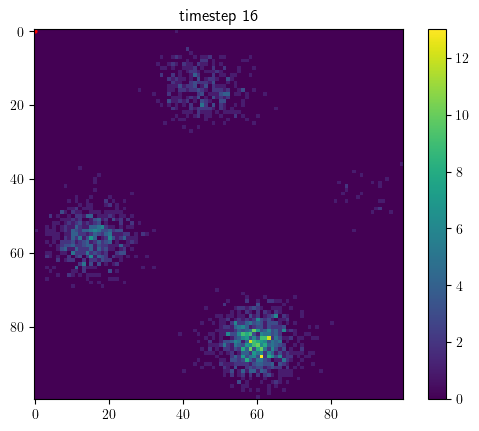

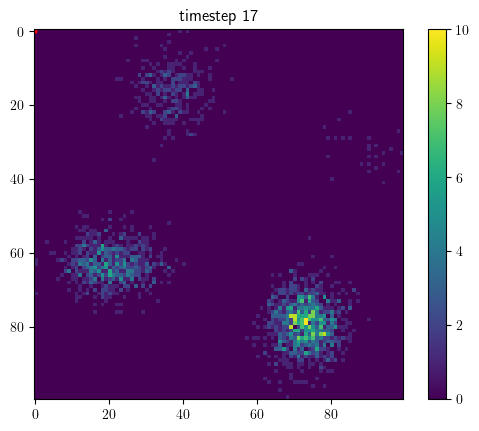

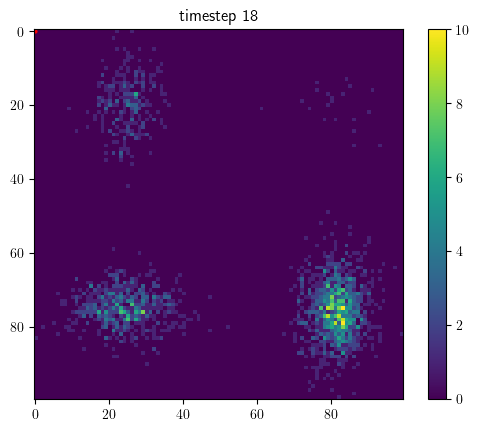

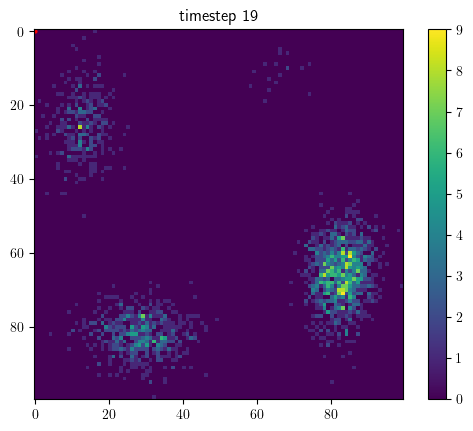

In [9]:
for i in range(20):
    plt.figure()
    hist_counts, bins_x, bins_y = np.histogram2d(particle_locs_and_hd[i][:, 0], particle_locs_and_hd[i][:, 1], bins=100)
    cb = plt.imshow(hist_counts, cmap="viridis")
    loc_rescaled = true_locs[i]
    loc_rescaled[0] = np.where((loc_rescaled[0] > bins_x))[0][0]
    loc_rescaled[1] = np.where((loc_rescaled[1] > bins_y))[0][0]
    plt.scatter(loc_rescaled[0], loc_rescaled[1], color="red", s=4)
    plt.title(f"timestep {i}")
    plt.colorbar(cb)

In [2]:
env = LargeSquare(contrast=0.5, contrast_btw_walls=0.0, height_wall=.3) # contrast between walls, consider 0.3
retina = Retina(fov_deg=(90., 90.), deg_per_pix=2.)
gen_cont = GenerativeModelSingleEnvContTabular(env=env, retina=retina)
obs_cont = ObserverNav(gen_cont, (0., 0.),
                            .85, (0.3, 0.), init_num_particles=5000)


agent_pos = torch.tensor([0.3, 0.3, 120.])
control = Control(15, (0.1, 0.))
obs_cont.gen.agent_state.set_state((agent_pos[0], agent_pos[1]), agent_pos[2])
obs_cont.measurement_step(obs_cont.gen.meas, update_state=True)

# plot_particles(obs_cont)
# plot_visual(obs_cont)
# plot_visual(obs_cont, loc=obs_cont.particles.loc[torch.argmax(obs_cont.particles.weight)])
obs_cont.resample_cont(MH=False)
obs_cont.measurement_step(obs_cont.gen.meas, update_state=True)

# plot_visual(obs_cont, i=-1)
# plot_particles(obs_cont)
obs_cont.particles.downsample(2048)

********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [15]:
particle_locs_and_hd = np.zeros((21, 2048, 3))
true_locs = np.zeros((21, 2))
true_hd = np.zeros((21, 1))
particle_weights = np.zeros((21, 2048,))

particle_locs_and_hd[0] = obs_cont.particles.loc
particle_weights[0] = obs_cont.particles.weight
true_locs[0] = obs_cont.gen.agent_state.loc_xy
true_hd[0] = obs_cont.gen.agent_state.heading_deg

In [16]:

with trange(20, dynamic_ncols=True) as pbar:
    for i in pbar:
        update_state(obs_cont, control)

        obs_cont.transition_step(control=control)
        obs_cont.measurement_step(obs_cont.gen.meas, update_state=True)
        # plot_particles(obs_cont, title=(i, 'predicted', 1 / torch.sum(obs_cont.particles.weight ** 2)))

        if (1 / torch.sum(obs_cont.particles.weight ** 2) <
            0.1 * obs_cont.particles.n_particle) and i % 5 == 4:
            obs_cont.resample_cont(MH=False)
        
        particle_locs_and_hd[i+1] = obs_cont.particles.loc
        particle_weights[i+1] = obs_cont.particles.weight
        true_locs[i+1] = obs_cont.gen.agent_state.loc_xy
        true_hd[i+1] = obs_cont.gen.agent_state.heading_deg

100%|██████████| 20/20 [04:39<00:00, 13.99s/it]


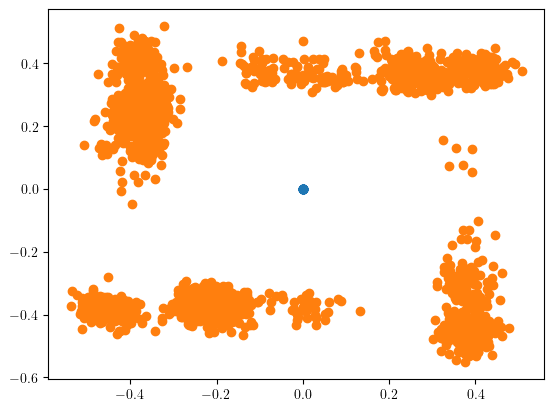

In [37]:
plt.scatter(true_locs[:, 0], true_locs[:, 1])
plt.scatter(particle_locs_and_hd[1][:, 0], particle_locs_and_hd[1][:, 1])

In [30]:
for i in range(21):
    hist_counts, bins_x, bins_y = np.histogram2d(particle_locs_and_hd[i][:, 0], particle_locs_and_hd[i][:, 1], bins=100)
    cb = plt.imshow(hist_counts, cmap="viridis")
    loc_rescaled = true_locs[i]
    loc_rescaled[0] = np.where((loc_rescaled[0] > bins_x))[0][0]
    loc_rescaled[1] = np.where((loc_rescaled[1] > bins_y))[0][0]
    plt.scatter(loc_rescaled[0], loc_rescaled[1], color="red", s=4)
    plt.title(f"timestep {i}")
    plt.colorbar(cb)
    
    plt.savefig(f"../figures/test_bion_rectangle/ts_{i}.png")
    
    plt.close("all")

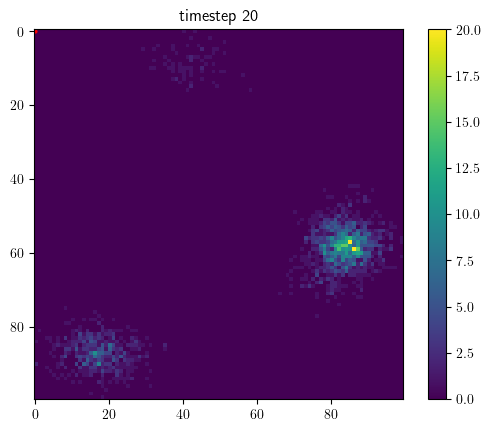

In [31]:
hist_counts, bins_x, bins_y = np.histogram2d(particle_locs_and_hd[i][:, 0], particle_locs_and_hd[i][:, 1], bins=100)
cb = plt.imshow(hist_counts, cmap="viridis")
loc_rescaled = true_locs[i]
loc_rescaled[0] = np.where((loc_rescaled[0] > bins_x))[0][0]
loc_rescaled[1] = np.where((loc_rescaled[1] > bins_y))[0][0]
plt.scatter(loc_rescaled[0], loc_rescaled[1], color="red", s=4)
plt.title(f"timestep {i}")
plt.colorbar(cb)

In [36]:
true_locs

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [33]:
np.where((loc_rescaled[0] > bins_x))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),)

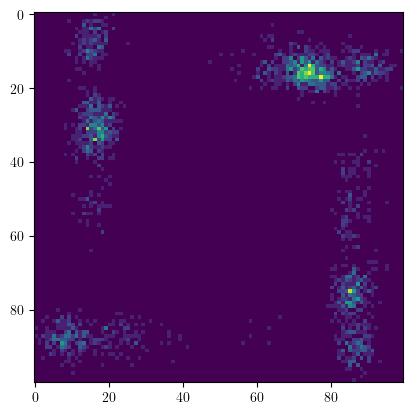

In [24]:
plt.imshow(hist_counts)

In [16]:
obs_cont.measurement_step(obs_cont.gen.meas, update_state=True)

tensor([1.3738e-04, 1.0053e-07, 8.7880e-06,  ..., 2.4055e-04, 5.1054e-04,
        1.1051e-04])

In [1]:
i = 0
if (1 / torch.sum(obs_cont.particles.weight ** 2) <
    0.1 * obs_cont.particles.n_particle) and i % 5 == 4:
    obs_cont.resample_cont(MH=False)

NameError: name 'torch' is not defined

In [6]:
noise_control_rotate_pconc = None
noise_control_shift = None
noise_control_shift_per_speed = None

if noise_control_rotate_pconc is None:
    noise_control_rotate_pconc = obs_cont.noise_control_rotate_pconc[0]
else:
    noise_control_rotate_pconc = noise_control_rotate_pconc + \
                                    npt_zeros_like(
                                        obs_cont.noise_control_rotate_pconc[0])

if noise_control_shift is None:
    noise_control_shift = obs_cont.noise_control_shift[:]
else:
    noise_control_shift = noise_control_shift + npt_zeros_like(
        obs_cont.noise_control_shift[:])

if noise_control_shift_per_speed is None:
    noise_control_shift_per_speed = \
        obs_cont.noise_control_shift_per_speed[:]
else:
    noise_control_shift_per_speed = \
        noise_control_shift_per_speed + npt_zeros_like(
            obs_cont.noise_control_shift_per_speed[:])

In [7]:
headings = obs_cont.particles.loc[..., -1] + torch.rad2deg(
            distributions.VonMises(torch.deg2rad(control.dheading_deg[..., -1]) * obs_cont.dt,
                                    pconc2conc(noise_control_rotate_pconc) /
                                    (torch.abs(torch.deg2rad(control.dheading_deg[..., -1]))
                                    * obs_cont.dt)
                                    ).sample(torch.Size([obs_cont.particles.n_particle])))

In [8]:
rate = (control.velocity_ego[0] /
        (obs_cont.dt * control.velocity_ego[0] * noise_control_shift_per_speed[0]) ** 2)
conc = control.velocity_ego[0] * rate

tensor(0.1000, dtype=torch.float32)

In [14]:
rate.dtype

torch.float32

In [14]:
rot = torch.stack([torch.stack([torch.cos(deg2rad(headings)),
                    torch.sin(deg2rad(headings))], -1),
        torch.stack([-torch.sin(deg2rad(headings)),
                    torch.cos(deg2rad(headings))], -1)],
        -1)

In [15]:
new_loc = obs_cont.particles.loc[..., :2] + (rot @ torch.stack(
    [distributions.Gamma(conc,
                            rate).rsample([obs_cont.particles.n_particle]),
        distributions.Normal(0, (obs_cont.dt *
                                control.velocity_ego[0] *
                                noise_control_shift_per_speed[1]) ** 2).rsample(
            [obs_cont.particles.n_particle])], -1)[..., None])[..., 0]

In [10]:
distributions.Gamma(conc,rate).rsample([obs_cont.particles.n_particle]).dtype

torch.float64

In [7]:
with open("../logdir/test_bion_rectangle/S20_T20_P2048.pkl", "rb") as f:
    d = pickle.load(f)
f.close()

particle_loc_and_hd = d["particle_state"]
particle_weights = d["particle_weight"]
true_locs = d["true_locs"]
true_hd = d["true_hd"]

In [10]:
particle_locs_flatten = particle_loc_and_hd[..., :2][:, 1:, ...].reshape(-1, 2048, 2)
true_locs_flatten = true_locs[:, 1:, :].reshape(-1, 2)
particle_weights_flatten = particle_weights[:, 1:, ...].reshape(-1, 2048)

In [11]:
particle_locs_flatten.shape

(400, 2048, 2)

In [12]:
true_locs_flatten.shape

(400, 2)

In [13]:
particle_weights_flatten.shape

(400, 2048)

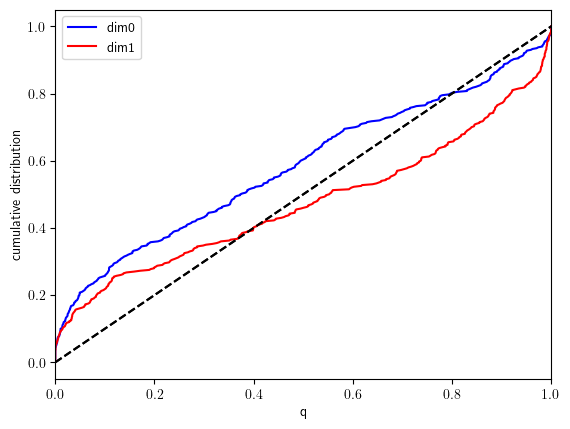

In [21]:
fig, ax = plt.subplots()
_, _ = inverse_transform_evaluation_partical_filtering(particle_locs_flatten, true_locs_flatten, particle_weights_flatten, dim=0, label="dim0", ax=ax, color="blue")
_, _ = inverse_transform_evaluation_partical_filtering(particle_locs_flatten, true_locs_flatten, particle_weights_flatten, dim=1, label="dim1", ax=ax, color="red")
ax.legend()